# konlpy 설치

In [ ]:
! sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
! sudo apt-get install python3-dev; pip3 install konlpy
! sudo apt-get install curl
! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [9]:
from konlpy.tag import Mecab

mecab = Mecab()
mecab.morphs('안녕하세요 제 이름은 박도준입니다.')

['안녕', '하', '세요', '제', '이름', '은', '박도준', '입니다', '.']

# 네이버 영화 리뷰 불러오기

In [12]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
cd /content/drive/MyDrive/edu

/content/drive/MyDrive/edu


In [13]:
# 로컬 파일로 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f462544dda0>)

In [16]:
# 로컬 파일 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [17]:
## 자료갯수를 임의로 축소
train_data=train_data[:5000]
test_data=test_data[:1000]

In [18]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 정제

In [ ]:
# 학습 데이터의 편향 확인

train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

총 샘플의 수 : 4973


,label,count
0,0,2490
1,1,2483


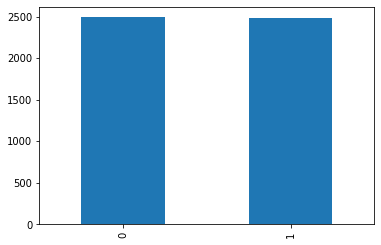

In [29]:
# document 열의 중복데이터가 있으면 해당 행을 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

print('총 샘플의 수 :',len(train_data))
display(train_data.groupby('label').size().reset_index(name = 'count'))
train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

In [35]:
print(train_data.isnull().values.any())  # null값 확인
print(train_data.isnull().sum())         # 열별 null 갯수
train_data.loc[train_data.document.isnull()]  # null이 있는 행 출력

False
id          0
document    0
label       0
dtype: int64


,id,document,label


In [39]:
# 정규표현식으로 한글과 공백외 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣 ]","")
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [40]:
train_data['document'].replace('', np.nan, inplace=True)  # 아무 값이 없는 데이터를 null로 변경
print(train_data.isnull().sum())    # null 다시 확인

train_data.loc[train_data.document.isnull()].head()

id           0
document    20
label        0
dtype: int64


,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [41]:
# null값을 가진 샘플 제거
train_data = train_data.dropna(how = 'any')  # null이 존재하는 행 제거

print(train_data.isnull().values.any()) # null이 존재하는지 확인
print(len(train_data))                  # 전체 데이터 갯수
print(train_data.info())                # 데이터 정보

False
4953
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4953 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4953 non-null   int64 
 1   document  4953 non-null   object
 2   label     4953 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 154.8+ KB
None


In [42]:
# 테스트 데이터에 대해 동일하게 정제
test_data.drop_duplicates(subset = ['document'], inplace=True)   # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print(len(test_data))
print(train_data.info())

989
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4953 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4953 non-null   int64 
 1   document  4953 non-null   object
 2   label     4953 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 154.8+ KB
None


# 토큰화

In [58]:
X_train = []
for sentence in train_data['document']:
    temp_X = mecab.nouns(sentence) # 토큰화
    # temp_X = mecab.morphs(sentence)
    #temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = mecab.nouns(sentence) # 토큰화
    # temp_X = mecab.morphs(sentence)  
    #temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [59]:
print(X_train[:3])

[['짜증', '나', '목소리'], ['포스터', '초딩', '영화', '줄', '오버', '연기'], []]


In [60]:
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
tokenizer = tf.keras.preprocessing.text.Tokenizer() 

tokenizer.fit_on_texts(X_train) 
print("word_index : ",tokenizer.word_index)
print(len(tokenizer.word_index))

word_index :  {'영화': 1, '것': 2, '거': 3, '점': 4, '수': 5, '연기': 6, '최고': 7, '평점': 8, '사람': 9, '나': 10, '때': 11, '드라마': 12, '말': 13, '스토리': 14, '듯': 15, '감동': 16, '게': 17, '내용': 18, '내': 19, '감독': 20, '생각': 21, '시간': 22, '배우': 23, '재미': 24, '년': 25, '사랑': 26, '중': 27, '하나': 28, '번': 29, '작품': 30, '쓰레기': 31, '이거': 32, '정도': 33, '이건': 34, '액션': 35, '돈': 36, '줄': 37, '개': 38, '마지막': 39, '잼': 40, '만': 41, '주인공': 42, '끝': 43, '장면': 44, '건': 45, '기대': 46, '이야기': 47, '분': 48, '최악': 49, '걸': 50, '남자': 51, '명작': 52, '이게': 53, '기억': 54, '애': 55, '느낌': 56, '난': 57, '뭐': 58, '인생': 59, '우리': 60, '이상': 61, '연출': 62, '일': 63, '현실': 64, '짜증': 65, '이해': 66, '가슴': 67, '한국': 68, '소재': 69, '여자': 70, '처음': 71, '매력': 72, '데': 73, '전': 74, '일본': 75, '편': 76, '실망': 77, '필요': 78, '전개': 79, '결말': 80, '마음': 81, '굿': 82, '때문': 83, '음악': 84, '씨': 85, '속': 86, '이': 87, '인간': 88, '공포': 89, '표현': 90, '자체': 91, '몰입': 92, '코미디': 93, '반전': 94, '공감': 95, '기분': 96, '밋': 97, '작가': 98, '캐릭터': 99, '수준': 100, '건지': 101, '제목': 10

In [61]:
# 단어빈도수 확인
threshold = 3
total_cnt = len(tokenizer.word_index)   # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 5748
등장 빈도가 2번 이하인 희귀 단어의 수: 4241
단어 집합에서 희귀 단어의 비율: 73.78218510786361
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 18.966603654694392


In [62]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1509


In [63]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:20])
print(len(X_train))

[[66, 11, 422], [192, 258, 2, 38, 695, 7], [], [1, 48, 25, 9, 1], [1, 1, 7, 2, 373, 1, 1], [1, 1096, 423, 281, 514, 1, 2, 39], [107, 153], [374, 119, 1, 1, 7, 836, 26, 317, 424, 1, 1, 375, 375, 13, 104, 7, 10], [36, 25, 2], [9, 318, 42, 837], [], [12, 26, 376, 838, 425, 1, 297, 592, 1097, 1098], [1, 1, 12, 139, 1, 7], [1, 696, 120, 10, 3], [377, 1099, 1100, 108, 2, 28, 41, 17, 15, 17, 839], [426, 840, 460, 98], [10, 18, 1101, 1, 1, 515, 1, 1, 1, 3], [1, 1, 461, 3, 67, 282], [35, 1102, 130, 19, 175, 1102, 516], [1, 1, 1, 169]]
4953


In [64]:
print(tokenizer.word_index)

{'OOV': 1, '영화': 2, '것': 3, '거': 4, '점': 5, '수': 6, '연기': 7, '최고': 8, '평점': 9, '사람': 10, '나': 11, '때': 12, '드라마': 13, '말': 14, '스토리': 15, '듯': 16, '감동': 17, '게': 18, '내용': 19, '내': 20, '감독': 21, '생각': 22, '시간': 23, '배우': 24, '재미': 25, '년': 26, '사랑': 27, '중': 28, '하나': 29, '번': 30, '작품': 31, '쓰레기': 32, '이거': 33, '정도': 34, '이건': 35, '액션': 36, '돈': 37, '줄': 38, '개': 39, '마지막': 40, '잼': 41, '만': 42, '주인공': 43, '끝': 44, '장면': 45, '건': 46, '기대': 47, '이야기': 48, '분': 49, '최악': 50, '걸': 51, '남자': 52, '명작': 53, '이게': 54, '기억': 55, '애': 56, '느낌': 57, '난': 58, '뭐': 59, '인생': 60, '우리': 61, '이상': 62, '연출': 63, '일': 64, '현실': 65, '짜증': 66, '이해': 67, '가슴': 68, '한국': 69, '소재': 70, '여자': 71, '처음': 72, '매력': 73, '데': 74, '전': 75, '일본': 76, '편': 77, '실망': 78, '필요': 79, '전개': 80, '결말': 81, '마음': 82, '굿': 83, '때문': 84, '음악': 85, '씨': 86, '속': 87, '이': 88, '인간': 89, '공포': 90, '표현': 91, '자체': 92, '몰입': 93, '코미디': 94, '반전': 95, '공감': 96, '기분': 97, '밋': 98, '작가': 99, '캐릭터': 100, '수준': 101, '건지': 102, '제목': 103,

In [65]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [67]:
## 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

4733
4733


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [71]:
len(drop_train)  # 빈 샘플 갯수

220

# 패딩

리뷰의 최대 길이 : 30
리뷰의 평균 길이 : 5.700190154236214


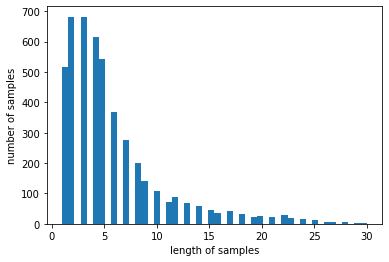

In [72]:
# 문장 길이 정보

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [74]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [76]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [75]:
# 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)
print(X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0
[[   0    0    0 ...   66   11  422]
 [   0    0    0 ...   38  695    7]
 [   0    0    0 ...   25    9    1]
 ...
 [   0    0    0 ... 1442   19  235]
 [   0    0    0 ...    1    1 1507]
 [   0    0    0 ...  198  914   19]]


# 모델링

In [77]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(300))
model.add(Dense(1, activation='sigmoid'))

In [79]:
vocab_size

1509

In [80]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(300))
model.add(Dense(1, activation='sigmoid'))

In [81]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])  # 모델 컴파일

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         150900    
_________________________________________________________________
lstm (LSTM)                  (None, 300)               481200    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 632,401
Trainable params: 632,401
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [83]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
64/64 [==============================] - 16s 218ms/step - loss: 0.6876 - acc: 0.5640 - val_loss: 0.6073 - val_acc: 0.7033

Epoch 00001: val_acc improved from -inf to 0.70327, saving model to best_model.h5
Epoch 2/15
64/64 [==============================] - 14s 218ms/step - loss: 0.5573 - acc: 0.7439 - val_loss: 0.5526 - val_acc: 0.6948

Epoch 00002: val_acc did not improve from 0.70327
Epoch 3/15
64/64 [==============================] - 14s 218ms/step - loss: 0.4753 - acc: 0.7728 - val_loss: 0.5556 - val_acc: 0.7149

Epoch 00003: val_acc improved from 0.70327 to 0.71489, saving model to best_model.h5
Epoch 4/15
64/64 [==============================] - 14s 220ms/step - loss: 0.4454 - acc: 0.7863 - val_loss: 0.5552 - val_acc: 0.7276

Epoch 00004: val_acc improved from 0.71489 to 0.72756, saving model to best_model.h5
Epoch 5/15
64/64 [==============================] - 14s 222ms/step - loss: 0.3982 - acc: 0.8079 - val_loss: 0.5613 - val_acc: 0.7086

Epoch 00005: val_acc did not

# 모델 테스트

In [84]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

31/31 [==============================] - 2s 39ms/step - loss: 0.5837 - acc: 0.6997

 테스트 정확도: 0.6997


In [86]:
loaded_model.evaluate(X_test, y_test)

31/31 [==============================] - 1s 38ms/step - loss: 0.5837 - acc: 0.6997


[0.5836958885192871, 0.6996966600418091]

In [89]:
# 텍스트를 입력받아 긍부정 평가하기

def sentiment_predict(new_sentence):
  new_sentence = mecab.nouns(new_sentence) # 토큰화
  #new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [88]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

63.02% 확률로 긍정 리뷰입니다.



In [90]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

65.34% 확률로 부정 리뷰입니다.

